<h1><b>mobilenetV2</b></h1>

In [51]:
import pandas as pd
import numpy as np

In [52]:
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from tensorflow.keras.optimizers import Adam 
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import Sequence, to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import PIL
import cv2
import tensorflow as tf
import pandas as pd
# import imgaug as ia
import numpy as np

# from imgaug import augmenters as iaa

from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

## Save Figures

In [9]:
# Write a function to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Figures")
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<p style="color:blue"><b>START: DATA</b></p>

In [53]:
df=pd.read_csv("dataset.csv")

In [54]:
df["Diagnosis"].value_counts()

0    2500
1    2500
Name: Diagnosis, dtype: int64

In [55]:
df=df.drop(labels='Unnamed: 0',axis=1)

In [56]:
df.head(n=2)

,Patient ID,Diagnosis,Pathes
0,12906,0,archive/12906/0/12906_idx5_x1051_y1301_class0.png
1,16568,0,archive/16568/0/16568_idx5_x1151_y1201_class0.png


<p>train test split</p>

In [57]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.3,random_state=8)

In [58]:
df_test , df_evaluate = train_test_split(df_test,test_size=0.3,random_state=8)

In [59]:
df_test["Diagnosis"].value_counts()

0    539
1    511
Name: Diagnosis, dtype: int64

In [60]:
df_evaluate["Diagnosis"].value_counts()

1    237
0    213
Name: Diagnosis, dtype: int64

In [61]:
df_train.head(n=2)

,Patient ID,Diagnosis,Pathes
4215,13617,0,archive/13617/0/13617_idx5_x1401_y151_class0.png
3847,9323,0,archive/9323/0/9323_idx5_x1801_y1251_class0.png


In [62]:
df_test.head(n=2)

,Patient ID,Diagnosis,Pathes
22,15633,1,archive/15633/1/15633_idx5_x1551_y451_class1.png
2735,9123,0,archive/9123/0/9123_idx5_x951_y2301_class0.png


In [63]:
df_train["Diagnosis"].value_counts()

1    1752
0    1748
Name: Diagnosis, dtype: int64

In [64]:
df_test["Diagnosis"].value_counts()

0    539
1    511
Name: Diagnosis, dtype: int64

<p>getting the training data from directory</p>

In [65]:
from PIL import Image
# random_train['Pixels']=np.array(random_train['Pathes'].map(lambda x:np.asarray(open(x).resize((128,128)))))
# X_train_mobilenet=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((128,128))))
X_train_mobilenet=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x)))


In [66]:
y_train_mobilenet = np.array(df_train['Diagnosis'])

<p style="color:blue"><b>FINISH: DATA</b></p>

<b>start: data generator</b>

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [68]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224)
train_batches = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


Found 3500 validated image filenames.


In [69]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   )
test_batches = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 1050 validated image filenames.


In [70]:
valid_batches = test_datagen.flow_from_dataframe(dataframe=df_evaluate,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 450 validated image filenames.


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
num_classes = 1
model = Sequential([
     MobileNetV2(input_shape=(224,224,3),weights="imagenet",include_top=False), 
     GlobalAveragePooling2D(),
     Dense(num_classes, activation='sigmoid',name='preds'),
])
model.layers[0].trainable= False
# show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 preds (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [72]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1,
    )
]

In [113]:
model.compile(optimizer='adam',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])
trained_MobileNetV2 = model.fit_generator(train_batches,
#           validation_data=test_batches,
          validation_data=valid_batches,
          epochs=20,
#           validation_split=0.2,
          verbose=1,
          callbacks=[callbacks]
         )

C:\Users\fahim\AppData\Local\Temp/ipykernel_33696/3573417681.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  trained_MobileNetV2 = model.fit_generator(train_batches,


Epoch 1/20
55/55 [==============================] - 63s 1s/step - loss: 0.5191 - accuracy: 0.7520 - val_loss: 0.4366 - val_accuracy: 0.8000
Epoch 2/20
55/55 [==============================] - 59s 1s/step - loss: 0.4510 - accuracy: 0.7997 - val_loss: 0.4120 - val_accuracy: 0.8111
Epoch 3/20
55/55 [==============================] - 58s 1s/step - loss: 0.4361 - accuracy: 0.8086 - val_loss: 0.4138 - val_accuracy: 0.8133
Epoch 4/20
55/55 [==============================] - 58s 1s/step - loss: 0.4347 - accuracy: 0.8103 - val_loss: 0.4076 - val_accuracy: 0.8222
Epoch 5/20
55/55 [==============================] - 58s 1s/step - loss: 0.4317 - accuracy: 0.8174 - val_loss: 0.4026 - val_accuracy: 0.8133
Epoch 5: early stopping


In [114]:
model_mobilenet_score = model.evaluate(test_batches)

17/17 [==============================] - 17s 993ms/step - loss: 0.4342 - accuracy: 0.8048


In [115]:
from sklearn.metrics import classification_report , confusion_matrix
y_pred_mobilenet_aug=(model.predict(test_batches) > 0.5).astype("int32")

In [116]:
y_pred_mobilenet_aug.shape

(1050, 1)

In [117]:
print(classification_report(y_pred_mobilenet_aug,np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       530
           1       0.82      0.81      0.81       520

    accuracy                           0.82      1050
   macro avg       0.82      0.82      0.82      1050
weighted avg       0.82      0.82      0.82      1050



In [118]:
def plot_acc_loss(trained):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(trained.epoch, trained.history["loss"], label="Train loss")
    ax[0].plot(trained.epoch, trained.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(trained.epoch, trained.history["accuracy"], label="Train acc")
    ax[1].plot(trained.epoch, trained.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

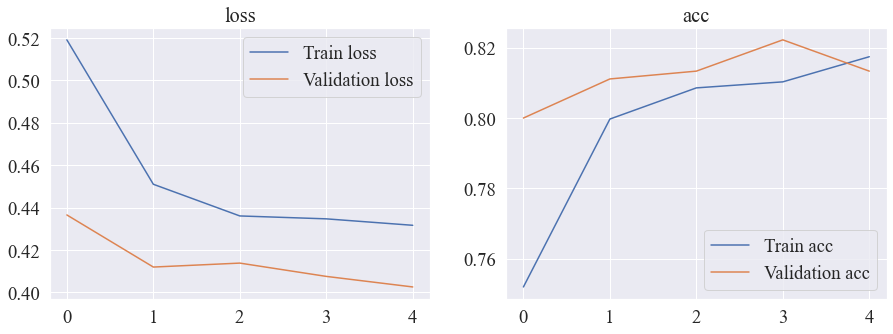

In [119]:
plot_acc_loss(trained_MobileNetV2)

In [ ]:
y_test = np.array(df_test["Diagnosis"]))

Saving figure Confusion_Matrix_Mobile_Net


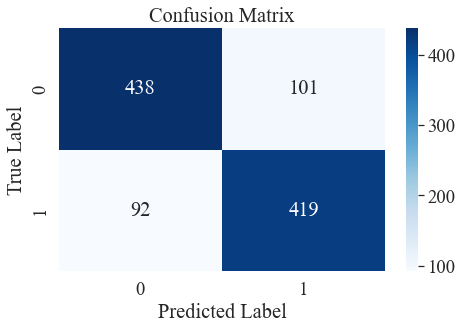

In [159]:
sns.set(font_scale=1.7)
plt.rcParams['font.family'] = "times new roman"

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_mobilenet_aug)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = [0, 1], 
                     columns = [0, 1])

#Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(7, 5))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)
sns.heatmap(cm_df, annot = True, fmt="d", cmap="Blues")
#
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

save_fig('Confusion_Matrix_Mobile_Net')
plt.show()

In [120]:
model.save("mobilenetV2.h5")

<b>feature map of mobilenetV2</b>

In [101]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import img_to_array
# # img = img_to_array(test)
# # expand dimensions so that it represents a single 'sample'

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# # X_train_mobilenet[0].shape
# img = X_train_mobilenet[0]
# img = np.expand_dims(img, axis=0)


In [102]:
# img.shape

(1, 50, 50, 3)

In [103]:
# first_feature_map = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[1].output)
# feature_map_1=first_feature_map.predict(img)

In [104]:
# feature_map_1.shape

(1, 1280)

In [105]:
# second_feature_map = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[2].output)
# feature_map_2=second_feature_map.predict(img)
# feature_map_2.shape

(1, 1)

<b>finish [datagen]</b>

In [112]:
df_train["Diagnosis"].value_counts()

1    1752
0    1748
Name: Diagnosis, dtype: int64

In [113]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
img_list = []
for i in range (0,len(X_train_mobilenet)):
    brain_img =np.array(X_train_mobilenet)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_train_mobilenet = np.array(img_list)

print(X_train_mobilenet.shape)

(3500, 128, 128, 3)


model

In [114]:
from keras.models import Sequential
from keras.layers import Dense , GlobalAveragePooling2D
from keras.applications import MobileNetV2
num_classes = 1
model = Sequential([
     MobileNetV2(input_shape=(224,224,3),weights="imagenet",include_top=False), 
     GlobalAveragePooling2D(),
     Dense(num_classes, activation='sigmoid',name='preds'),
])
model.layers[0].trainable= False
# show model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [115]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1,
    )
]

In [116]:
model.compile(optimizer='adam',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])
model.fit(X_train_mobilenet,
          y_train_mobilenet,
          epochs=20,
          validation_split=0.2,
          verbose=1
         )

Epoch 1/20
88/88 [==============================] - 38s 435ms/step - loss: 0.6040 - accuracy: 0.6907 - val_loss: 0.4574 - val_accuracy: 0.7886
Epoch 2/20
88/88 [==============================] - 37s 426ms/step - loss: 0.4549 - accuracy: 0.7993 - val_loss: 0.4311 - val_accuracy: 0.8129
Epoch 3/20
88/88 [==============================] - 38s 432ms/step - loss: 0.4159 - accuracy: 0.8246 - val_loss: 0.4281 - val_accuracy: 0.8071
Epoch 4/20
88/88 [==============================] - 38s 429ms/step - loss: 0.3947 - accuracy: 0.8343 - val_loss: 0.4141 - val_accuracy: 0.8157
Epoch 5/20
88/88 [==============================] - 37s 425ms/step - loss: 0.3818 - accuracy: 0.8332 - val_loss: 0.4095 - val_accuracy: 0.8214
Epoch 6/20
88/88 [==============================] - 38s 433ms/step - loss: 0.3638 - accuracy: 0.8486 - val_loss: 0.4166 - val_accuracy: 0.8057
Epoch 7/20
88/88 [==============================] - 38s 429ms/step - loss: 0.3554 - accuracy: 0.8536 - val_loss: 0.4097 - val_accuracy: 0.8200

test

In [117]:
X_test_mobilenet=df_test['Pathes'].map(lambda x:np.asarray(open(x).resize((128,128))))

In [118]:
y_test_mobilenet=np.array(df_test['Diagnosis'])

In [119]:
img_list = []
for i in range (0,len(X_test_mobilenet)):
    brain_img =np.array(X_test_mobilenet)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_test_mobilenet = np.array(img_list)
print(X_test_mobilenet.shape)

(1500, 128, 128, 3)


In [120]:
eval_score = model.evaluate(X_test_mobilenet,y_test_mobilenet)
print('The loss of the evaluation :'+' '+str(eval_score[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score[1]*100))

47/47 [==============================] - 16s 338ms/step - loss: 0.4494 - accuracy: 0.8067
The loss of the evaluation : 44.93723809719086
The accuracy of the evaluation : 80.66666722297668


In [121]:
from sklearn.metrics import classification_report , confusion_matrix
y_pred = model.predict_classes(X_test_mobilenet)


In [122]:
from sklearn.metrics import accuracy_score,f1_score
accuracy_score(y_test_mobilenet,y_pred)

0.8066666666666666

In [123]:
print(classification_report(y_test_mobilenet,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       752
           1       0.82      0.79      0.80       748

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500



saving weights and model

In [126]:
# model_json = model.to_json()
# with open("mobilenetV2_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("mobilenetv2_weight.h5")
# print("Saved model to disk")

ValueError: bad mode 'w'

In [129]:
model.save("mobilenetV2.h5")

<h1>Inception Resnet V2</h1>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import Sequence, to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import PIL
import cv2
import tensorflow as tf
import pandas as pd
# import imgaug as ia
import numpy as np

# from imgaug import augmenters as iaa

from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

%config InlineBackend.figure_format="svg"
%matplotlib inline

In [ ]:
df=pd.read_csv('dataset.csv')

In [ ]:
df.shape

In [ ]:
df.head(n=2)

In [ ]:
df=df.drop(labels='Unnamed: 0',axis=1)

In [ ]:
df["Diagnosis"].value_counts()

In [ ]:
df.shape

In [15]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df_train,df_validate=train_test_split(df_train, test_size=0.15,random_state=8)

In [135]:
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 2
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 20

In [136]:
df_train.shape

(3500, 3)

In [137]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [138]:
train_batches = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import Sequence, to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import PIL
import cv2
import tensorflow as tf
import pandas as pd
# import imgaug as ia
import numpy as np

# from imgaug import augmenters as iaa

from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

Found 3500 validated image filenames.


In [139]:

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
valid_batches = valid_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 1500 validated image filenames.


In [140]:
net = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))


In [141]:
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)


In [142]:
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True


In [30]:
from tensorflow.keras.optimizers import Adam
net_final.compile(
                  optimizer=Adam(lr=1e-2),
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
                 )

NameError: name 'net_final' is not defined

In [144]:
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Epoch 1/20
437/437 [==============================] - 4276s 10s/step - loss: 7.6529 - accuracy: 0.4991 - val_loss: 7.6686 - val_accuracy: 0.5000
Epoch 2/20
420/437 [===========================>..] - ETA: 2:28 - loss: 7.6686 - accuracy: 0.4994

KeyboardInterrupt: 

In [ ]:
model_json = net_final.to_json()
with open("inception_resnet_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("inception_resnet_weight.h5")
print("Saved model to disk")

<h1>Inception Resnet V2 [Transfer Learning]</h1>

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import os
import sys
from glob import glob
import cv2 
import time
import datetime

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [125]:
IMAGE_SIZE_INCEPTION = (75,75)
BATCH_SIZE = 64
NUM_CLASSES = 2

In [126]:
# model_inception = InceptionResNetV2(
#         input_shape = (IMAGE_SIZE_INCEPTION[0],IMAGE_SIZE_INCEPTION[1],3) ,
#         weights = 'imagenet',
#         include_top = False,
#         pooling='max'

# )
# model_inception.trainable = False

# x = Flatten()(model_inception.output)
# x = Dense(NUM_CLASSES, activation = 'softmax')(x)

# model1 = Model(inputs = model_inception.input , outputs = x)


# # # #
from tensorflow.keras import regularizers
model_inception = InceptionResNetV2(
        input_shape = (IMAGE_SIZE_INCEPTION[0],IMAGE_SIZE_INCEPTION[1],3) ,
        weights = 'imagenet',
        include_top = False,
        pooling='max'
)
x=model_inception.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(NUM_CLASSES-1, activation='sigmoid')(x)
model=Model(inputs=model_inception.input, outputs=output)
model.compile(Adamax(learning_rate=.01), loss='binary_crossentropy', metrics=['accuracy']) 

In [127]:
# model1.summary()

In [128]:
def scalar(img):
    return img/127.5-1

In [129]:
train_datagen = ImageDataGenerator(
    
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
#         shear_range=0.2,
        zoom_range=0.2,
#         channel_shift_range=10,
    
        horizontal_flip=True,
        vertical_flip = True,
#         fill_mode='nearest',
        preprocessing_function = scalar
)

In [130]:
train_batch = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE_INCEPTION,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

Found 3500 validated image filenames.


In [131]:
valid_datagen = ImageDataGenerator(preprocessing_function=scalar,
                                   
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
#                                    shear_range=0.2,
                                   zoom_range=0.2,
#                                    channel_shift_range=10,
                                   
                                   horizontal_flip=True,
                                   vertical_flip=True
#                                    fill_mode='nearest'
                                  )


In [132]:
valid_batches = valid_datagen.flow_from_dataframe(dataframe=df_evaluate,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE_INCEPTION,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 450 validated image filenames.


In [133]:
test_batches = valid_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Pathes",
                                                  y_col="Diagnosis",
                                                  target_size=IMAGE_SIZE_INCEPTION,
                                                  interpolation='bicubic',
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 1050 validated image filenames.


In [134]:
df_test["Diagnosis"].value_counts()

0    539
1    511
Name: Diagnosis, dtype: int64

In [135]:
# model1.compile(
#     Adamax(lr=.001),
#     loss = 'binary_crossentropy' , 
# #     optimizer = 'adam' , 
#     metrics = ['accuracy']
# )

In [136]:
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
# #         monitor="val_loss",
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-3,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=5,
#         verbose=1,
#     )
# ]

In [137]:
class LRA(tf.keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
#         print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
#         print_in_color(msg, (244,252,3), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:60s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
#         print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
#             print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [138]:
# net1 = model1.fit(
#         train_batch,
#         validation_data = valid_batches,
#         epochs = 100,
#         callbacks = [callbacks]
# )


In [139]:
model_name = "InceptionResnetV2"
batch_size=64
train_steps = int(len(train_batch.labels)/batch_size)
epochs =20
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze,batches=train_steps, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

In [140]:
model1=model.fit(
    x=train_batch,  
    epochs=epochs, 
    verbose=2, 
    callbacks=callbacks,  
    validation_data=valid_batches,
#     validation_split=0.1,
    validation_steps=None,  
    shuffle=False,  
    initial_epoch=0
)

Epoch 1/20
55/55 - 123s - loss: 4.5480 - accuracy: 0.7266 - val_loss: 98554388480.0000 - val_accuracy: 0.4733 - 123s/epoch - 2s/step4804 
Epoch 2/20
55/55 - 110s - loss: 1.1104 - accuracy: 0.7951 - val_loss: 15947.0342 - val_accuracy: 0.7178 - 110s/epoch - 2s/step:  1.11039 
Epoch 3/20
55/55 - 111s - loss: 0.6399 - accuracy: 0.8163 - val_loss: 213.1586 - val_accuracy: 0.7244 - 111s/epoch - 2s/stepss:  0.63988 
Epoch 4/20
55/55 - 110s - loss: 0.5668 - accuracy: 0.8069 - val_loss: 2.3225 - val_accuracy: 0.8244 - 110s/epoch - 2s/steploss:  0.56681 
Epoch 5/20
55/55 - 110s - loss: 0.5264 - accuracy: 0.8243 - val_loss: 0.7224 - val_accuracy: 0.8489 - 110s/epoch - 2s/steploss:  0.52642 
Epoch 6/20
55/55 - 111s - loss: 0.5336 - accuracy: 0.8057 - val_loss: 0.6538 - val_accuracy: 0.8200 - 111s/epoch - 2s/steploss:  0.53361 
Epoch 7/20
55/55 - 112s - loss: 0.5110 - accuracy: 0.8197 - val_loss: 0.6321 - val_accuracy: 0.8356 - 112s/epoch - 2s/steploss:  0.51099 
Epoch 8/20
55/55 - 111s - loss: 0.

In [141]:
model.save("InceptionResnetV2.h5")

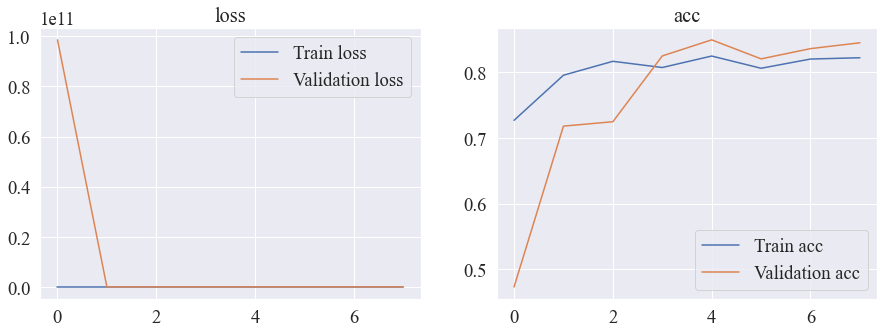

In [142]:
plot_acc_loss(model1)

In [143]:
model=load_model("InceptionResnetV2.h5")

In [144]:
from sklearn.metrics import classification_report , confusion_matrix
y_pred_inception_resnet=(model.predict(test_batches) > 0.5).astype("int32")

In [145]:
y_pred_inception_resnet

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [146]:
y_pred_inception_resnet = model.predict(test_batches)
predicted_categories_inception_resnet = (model.predict(test_batches) > 0.5).astype("int32")


In [147]:
predicted_categories_inception_resnet

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [149]:
# true_categories = tf.concat([y for x, y in test_batches], axis = 0).numpy()

In [150]:
# true_categories_argmax = np.argmax(true_categories, axis = 1)

In [151]:
# print(classification_report(true_categories_argmax, predicted_categories))

In [152]:
# print(np.argmax(y_pred_inception_resnet,axis=1))

In [153]:
#print(classification_report(y_pred_inception_resnet,np.array(df_test["Diagnosis"])))

print(classification_report((model.predict(test_batches) > 0.5).astype("int32"),np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       480
           1       0.86      0.77      0.82       570

    accuracy                           0.81      1050
   macro avg       0.81      0.81      0.81      1050
weighted avg       0.82      0.81      0.81      1050



In [155]:
y_pred = (model.predict(test_batches) > 0.5).astype("int32")
y_test = np.array(df_test["Diagnosis"])

Saving figure Confusion_Matrix_Inception_Res_Net


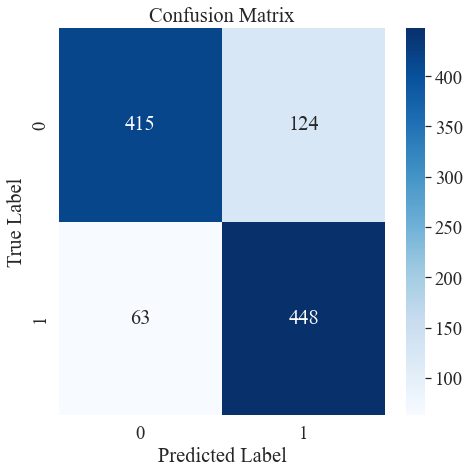

In [182]:
sns.set(font_scale=1.7)
plt.rcParams['font.family'] = "times new roman"

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = [0, 1], 
                     columns = [0, 1])

#Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)
sns.heatmap(cm_df, annot = True, fmt="d", cmap="Blues")
#
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#save_fig('Confusion_Matrix_Decision_Tree_GridSearch')
save_fig('Confusion_Matrix_Inception_Res_Net')
plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

In [ ]:
print_info( train_batch, y_pred_inception_resnet, print_code, save_dir, subject )

<h1>MLPClassifier</h1>

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import glob,os

In [74]:
from PIL import Image
# random_train['Pixels']=np.array(random_train['Pathes'].map(lambda x:np.asarray(open(x).resize((128,128)))))
# random_train['Pixels']=random_train.loc[:,['Pathes']].map(lambda x:np.asarray(open(x).resize((128,128))))
X_train_MLP=df_train['Pathes'].map(lambda x:np.asarray(Image.open(x).resize((50,50))))


In [75]:
X_train_MLP.shape

(3500,)

In [76]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
img_list = []
for i in range (0,len(X_train_MLP)):
    brain_img =np.array(X_train_MLP)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    img_list.append(preprocess_input(img_arr))
X_scaled = np.array(img_list)

print(X_scaled.shape)

(3500, 50, 50, 3)


In [77]:
X_scaled[0].shape

(50, 50, 3)

In [78]:
X_train_shape = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten = X_scaled.reshape(X_scaled.shape[0],X_train_shape)

In [79]:
X_Flatten.shape

(3500, 7500)

In [80]:
X_test_MLP=df_test["Pathes"].map(lambda x:np.asarray(Image.open(x).resize((50,50))))

In [81]:
image_list = []
for i in range (0,len(X_test_MLP)):
    brain_img =np.array(X_test_MLP)[i]
    img_arr = img_to_array(brain_img).astype(np.float32)
    image_list.append(preprocess_input(img_arr))
X_scaled_test = np.array(image_list)

print(X_scaled_test.shape)

(1050, 50, 50, 3)


In [82]:
X_test_shape = X_scaled_test.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten_test = X_scaled_test.reshape(X_scaled_test.shape[0],X_test_shape)

In [83]:
X_Flatten_test.shape

(1050, 7500)

In [84]:
clf=MLPClassifier(hidden_layer_sizes=(100,100),max_iter=400,verbose=2,early_stopping=True)
clf.fit(X_Flatten,np.array(df_train["Diagnosis"]))


Iteration 1, loss = 0.78580089
Validation score: 0.702857
Iteration 2, loss = 0.52593905
Validation score: 0.771429
Iteration 3, loss = 0.47907979
Validation score: 0.768571
Iteration 4, loss = 0.44530917
Validation score: 0.771429
Iteration 5, loss = 0.43146928
Validation score: 0.760000
Iteration 6, loss = 0.43706848
Validation score: 0.745714
Iteration 7, loss = 0.44704890
Validation score: 0.751429
Iteration 8, loss = 0.40188709
Validation score: 0.762857
Iteration 9, loss = 0.39416107
Validation score: 0.760000
Iteration 10, loss = 0.38951074
Validation score: 0.754286
Iteration 11, loss = 0.38103446
Validation score: 0.751429
Iteration 12, loss = 0.35435911
Validation score: 0.762857
Iteration 13, loss = 0.32846837
Validation score: 0.751429
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100), max_iter=400,
              verbose=2)

In [88]:
y_pred_MLP=clf.predict(X_Flatten_test)

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
accuracy_score(y_pred_MLP, np.array(df_test["Diagnosis"]))

0.7638095238095238

In [90]:
print(classification_report(y_pred_MLP, np.array(df_test["Diagnosis"])))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       493
           1       0.80      0.74      0.77       557

    accuracy                           0.76      1050
   macro avg       0.76      0.77      0.76      1050
weighted avg       0.77      0.76      0.76      1050



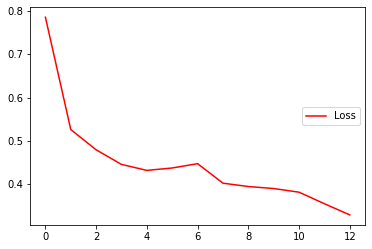

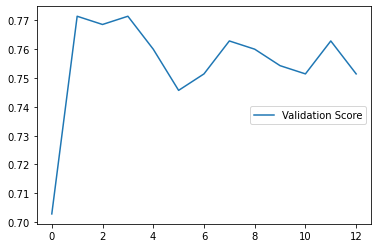

In [91]:
plt.plot(clf.loss_curve_, color='r')
plt.legend(["Loss"], loc ="right")
plt.show()
plt.plot(clf.validation_scores_)
plt.legend(["Validation Score"], loc ="right")
plt.show()


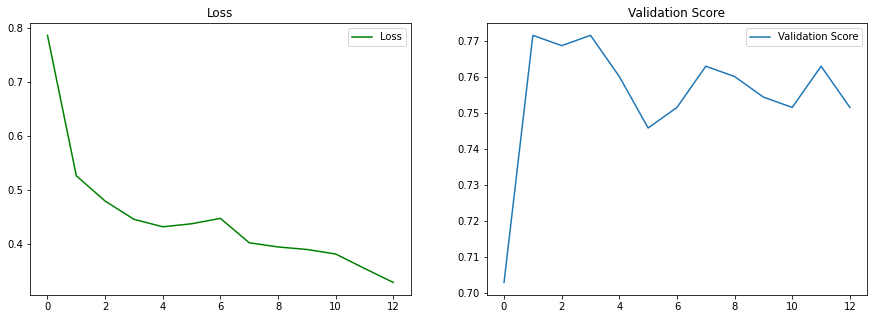

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(clf.loss_curve_, label="Loss", color='g')
ax[1].set_title('Validation Score')
ax[1].plot(clf.validation_scores_, label="Validation Score")
ax[0].legend()
ax[1].legend()

In [95]:
import seaborn as sns

In [98]:
y_test = np.array(df_test["Diagnosis"])
y_test

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [103]:
y_pred_MLP

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

Saving figure Confusion_Matrix_Decision_Tree_GridSearch
Saving figure Confusion_Matrix_MLP


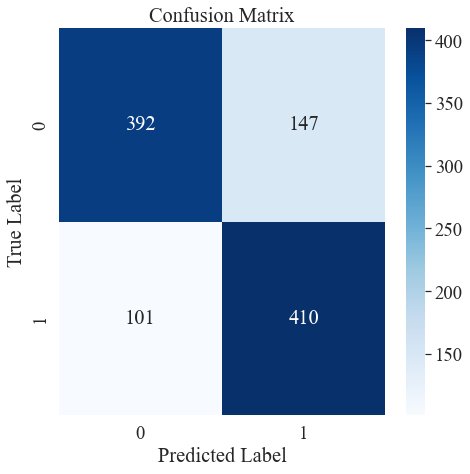

In [183]:
sns.set(font_scale=1.7)
plt.rcParams['font.family'] = "times new roman"

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_MLP)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = [0, 1], 
                     columns = [0, 1])

#Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)
sns.heatmap(cm_df, annot = True, fmt="d", cmap="Blues")
#
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

save_fig('Confusion_Matrix_Decision_Tree_GridSearch')
save_fig('Confusion_Matrix_MLP')
plt.show()

# Model Comparison

In [15]:
precision_list = [0.82, 0.82, 0.77,0.78,0.78]
recall_list = [0.82, 0.81, 0.76,0.78,0.78]
f1_list = [0.82, 0.81, 0.76,0.78,0.78]
accuracy_list = [0.82, 0.81, 0.76,0.78,0.78]
model_name = ['Mobile Net V2', 'Inception Resnet V2', 'Multi-Layer Perceptron','Logistic Regression','Logistic regression_PCA']

In [16]:
# sns.set(font_scale=1.2)
# sns.set_style("whitegrid", {'axes.grid' : False})

C:\Users\fahim\AppData\Local\Temp/ipykernel_24332/3544844525.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_name, fontdict=font2)


Saving figure Accuracy_of_Classification_Models


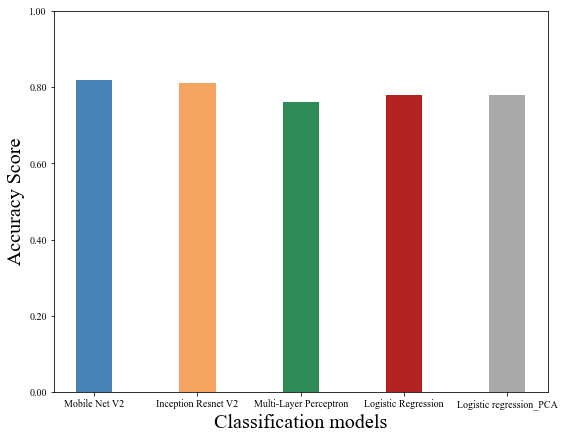

In [30]:
font = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

font2 = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6.2))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)

ax.bar(model_name, accuracy_list, width, color=['steelblue', 'sandybrown', 'seagreen', 'firebrick','darkgrey'])


ax.set_ylabel('Accuracy Score', fontdict=font)
ax.set_xlabel('Classification models', fontdict=font)
ax.set_xticklabels(model_name, fontdict=font2)
ax.set_yticks(list(filter(lambda x : x >= 0 and x<=100, ax.get_yticks().tolist())))
ax.set_yticklabels(labels=["{:.2f}".format(x) for x in ax.get_yticks().tolist()], fontdict=font2)
# ax.legend(prop={'family': 'times new roman', 'size': 17.5}).set_title(title='Academic performance',
#                                                                     prop={'family': 'times new roman', 'size': 17.5})


save_fig('Accuracy_of_Classification_Models')
plt.show()

C:\Users\fahim\AppData\Local\Temp/ipykernel_24332/2462699507.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_name, fontdict=font2)


Saving figure Precision_of_Classification_Models


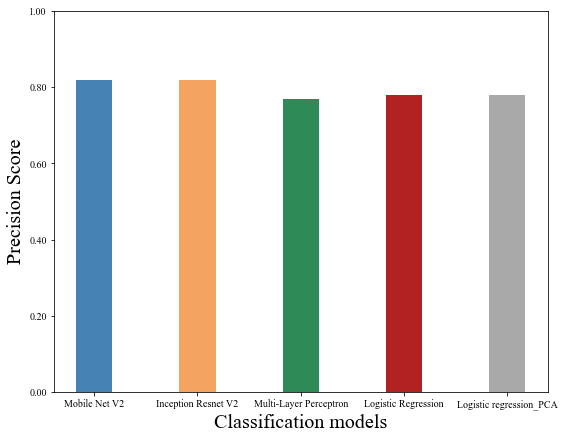

In [34]:
font = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

font2 = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6.2))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)

ax.bar(model_name, precision_list, width, color=['steelblue', 'sandybrown', 'seagreen', 'firebrick','darkgrey'])


ax.set_ylabel('Precision Score', fontdict=font)
ax.set_xlabel('Classification models', fontdict=font)
ax.set_xticklabels(model_name, fontdict=font2)
ax.set_yticks(list(filter(lambda x : x >= 0 and x<=100, ax.get_yticks().tolist())))
ax.set_yticklabels(labels=["{:.2f}".format(x) for x in ax.get_yticks().tolist()], fontdict=font2)
# ax.legend(prop={'family': 'times new roman', 'size': 17.5}).set_title(title='Academic performance',
#                                                                     prop={'family': 'times new roman', 'size': 17.5})


save_fig('Precision_of_Classification_Models')
plt.show()

C:\Users\fahim\AppData\Local\Temp/ipykernel_24332/4027380293.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_name, fontdict=font2)


Saving figure Recall_of_Classification_Models


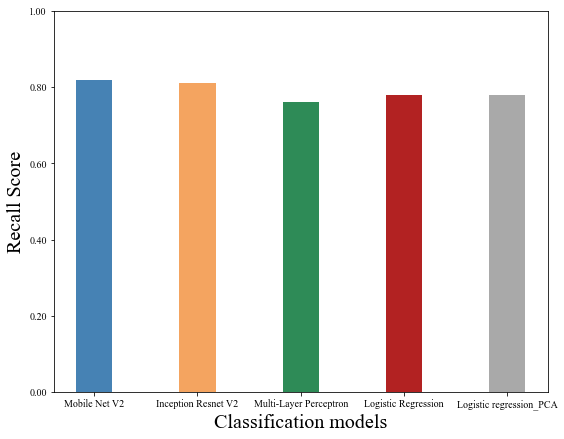

In [32]:
font = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

font2 = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6.2))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)

ax.bar(model_name, recall_list, width, color=['steelblue', 'sandybrown', 'seagreen', 'firebrick','darkgrey'])


ax.set_ylabel('Recall Score', fontdict=font)
ax.set_xlabel('Classification models', fontdict=font)
ax.set_xticklabels(model_name, fontdict=font2)
ax.set_yticks(list(filter(lambda x : x >= 0 and x<=100, ax.get_yticks().tolist())))
ax.set_yticklabels(labels=["{:.2f}".format(x) for x in ax.get_yticks().tolist()], fontdict=font2)
# ax.legend(prop={'family': 'times new roman', 'size': 17.5}).set_title(title='Academic performance',
#                                                                     prop={'family': 'times new roman', 'size': 17.5})


save_fig('Recall_of_Classification_Models')
plt.show()

C:\Users\fahim\AppData\Local\Temp/ipykernel_24332/3303389742.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_name, fontdict=font2)


Saving figure f1_of_Classification_Models


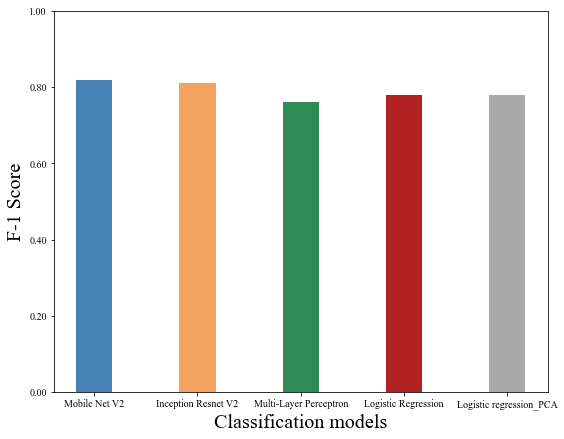

In [33]:
font = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

font2 = {'family': 'times new roman',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6.2))
fig.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.2)

ax.bar(model_name, f1_list, width, color=['steelblue', 'sandybrown', 'seagreen', 'firebrick','darkgrey'])


ax.set_ylabel('F-1 Score', fontdict=font)
ax.set_xlabel('Classification models', fontdict=font)
ax.set_xticklabels(model_name, fontdict=font2)
ax.set_yticks(list(filter(lambda x : x >= 0 and x<=100, ax.get_yticks().tolist())))
ax.set_yticklabels(labels=["{:.2f}".format(x) for x in ax.get_yticks().tolist()], fontdict=font2)
# ax.legend(prop={'family': 'times new roman', 'size': 17.5}).set_title(title='Academic performance',
#                                                                     prop={'family': 'times new roman', 'size': 17.5})


save_fig('f1_of_Classification_Models')
plt.show()